In [1]:
import pandas as pd

In [2]:
PATH = 'data/d.csv'

In [3]:
csv = pd.read_csv(PATH)

In [4]:
csv

,plant.ID,y,alpha
0,1,0,-4.159582
1,2,0,-3.718362
2,3,0,-3.069020
3,4,0,-3.054211
4,5,0,-2.880656
5,6,2,-2.705595
6,7,1,-2.441703
7,8,1,-2.221327
8,9,0,-2.209120
9,10,1,-2.111941


In [5]:
ys = csv['y'].values

In [6]:
import numpy as np

histo_ys = np.zeros(11)
for y in ys:
    histo_ys[y] += 1
print(histo_ys)
print(np.sum(histo_ys))

[  7.  10.  10.   5.  12.  11.  11.   7.  14.   9.   4.]
100.0


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

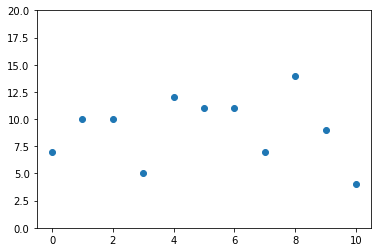

In [8]:
xs = np.arange(11)
plt.scatter(xs, histo_ys)
plt.ylim(0, 20)
plt.show()

In [9]:
import pymc3 as pm

In [10]:
ys

array([ 0,  0,  0,  0,  0,  2,  1,  1,  0,  1,  2,  2,  1,  1,  4,  1,  1,
        1,  1,  2,  4,  2,  2,  6,  2,  3,  0,  3,  6,  5,  2,  4,  1,  5,
        5,  3,  4,  4,  3,  5,  2,  3,  5,  6,  4,  4,  5,  2,  6,  6,  8,
        4,  6,  5,  5,  7,  4,  6,  4,  5,  5,  4,  6,  7,  4,  5,  6, 10,
        9, 10,  8,  7,  8,  6,  8,  8,  8,  9,  9,  8,  9,  7,  8,  7,  7,
        8,  8,  9,  8,  9,  9,  9,  8,  7,  6,  8,  8,  9, 10, 10])

In [11]:
model = pm.Model()
with model:
    q = pm.Uniform('q', lower=0, upper=1)
    y = pm.Binomial('y', n=10, p=q, observed=ys)
    map_estimate = pm.find_MAP(model=model)

logp = -316.78, ||grad|| = 4: 100%|██████████| 5/5 [00:00<00:00, 56.47it/s]


In [12]:
print((float(map_estimate['q'])))

0.4960000053023121


In [13]:
import scipy

In [14]:
rv = scipy.stats.binom(10, map_estimate['q'])
binom_ys = [100 * rv.pmf(k) for k in range(11)]

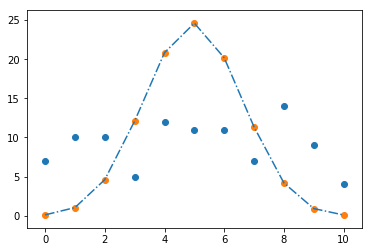

In [15]:
plt.scatter(xs, histo_ys)
plt.plot(xs, binom_ys, ls='-.')
plt.scatter(xs, binom_ys)
plt.show()

In [41]:
model = pm.Model()
with model:
    beta = pm.Normal('beta', mu=0, tau=1.0e-2)
    tau = pm.Gamma('tau', alpha=1.0e-02, beta=1.0e-02)
    alpha = pm.Normal('alpha', mu=0, tau=tau , shape=len(ys))
    ymu = pm.math.sigmoid(beta + alpha)
    y = pm.Binomial('y', n=10, p=ymu, observed=ys)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(5000, start=start, step=step)
alpha.shape

logp = -48.984, ||grad|| = 0.031497: 100%|██████████| 33/33 [00:00<00:00, 1646.55it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, beta]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:25<00:00, 847.82draws/s] 


Shape.0

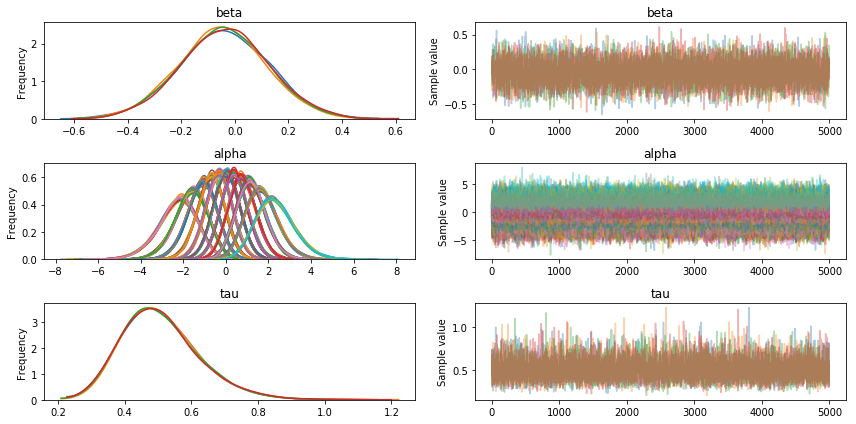

In [42]:
pm.traceplot(trace)
plt.figure(figsize=(10, 20))
plt.show()

In [43]:
beta_samples = trace['beta'][:]
print(beta_samples.shape)
beta_samples = beta_samples.reshape(-1, 1)
print(beta_samples.shape)

(20000,)
(20000, 1)


In [44]:
alpha_samples = trace['alpha'][:]
alpha_samples.shape

(20000, 100)

In [45]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [46]:
q_samples = sigmoid(beta_samples + alpha_samples)
q_samples.shape

(20000, 100)

In [47]:
# mean_q = q_samples.mean(axis=0)
# print(mean_q.shape)
# mean_q


In [49]:
# rows, = mean_q.shape
# rows
range(100)

range(0, 100)

In [53]:
import sys
rows, cols = q_samples.shape
rows = 1000
y_samples = np.zeros((cols, 11))
for col in range(cols):  # cols 100
    for row in range(rows):  # rows 10000
        rv = scipy.stats.binom(10, q_samples[row, col])
        y_samples[col] += [rv.pmf(k) for k in range(11)]
    y_samples[col] /= rows
pred_y = np.sum(y_samples, axis=0)

In [25]:
# y_samples = np.empty((100, 11))
# for i in range(rows):
#     rv = scipy.stats.binom(10, mean_q[i])
#     y_samples[i] = [rv.pmf(k) for k in range(11)]
# pred_y = np.sum(y_samples, axis=0)
# print(pred_y.shape)

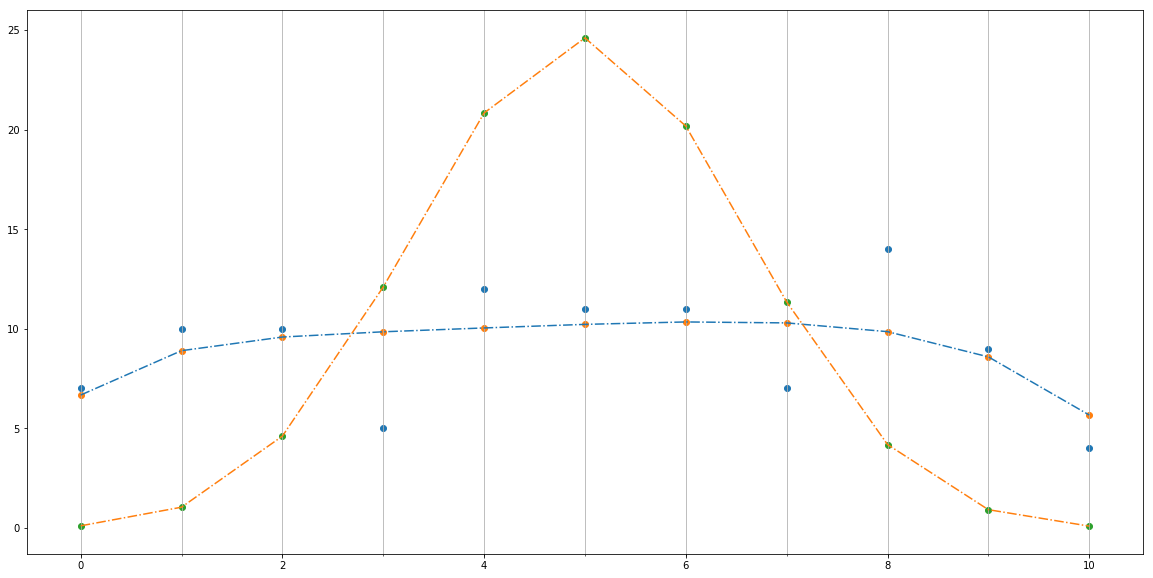

In [54]:
import matplotlib.ticker as tick
plt.figure(figsize=(20,10))
plt.scatter(xs, histo_ys)
plt.plot(xs, pred_y, ls='-.')
plt.scatter(xs, pred_y)
plt.plot(xs, binom_ys, ls='-.')
plt.scatter(xs, binom_ys)
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
# plt.legend(loc='best')
plt.show()

In [27]:
std_q = q_samples.std(axis=0)
print(std_q.shape)
std_q

(100,)


array([ 0.07982056,  0.08087231,  0.08089748,  0.08046042,  0.08150634,
        0.11882603,  0.10311828,  0.10316979,  0.0809328 ,  0.10172658,
        0.11789433,  0.11830568,  0.1019423 ,  0.10151322,  0.13524102,
        0.10226977,  0.1020199 ,  0.10047215,  0.10221656,  0.1192485 ,
        0.13573326,  0.11772267,  0.11831569,  0.1347396 ,  0.11788129,
        0.12905267,  0.08119979,  0.12941113,  0.13535306,  0.13876658,
        0.11810433,  0.13602932,  0.10109353,  0.13679281,  0.13729218,
        0.1282088 ,  0.1362246 ,  0.1338629 ,  0.12995849,  0.13802264,
        0.11933138,  0.12908109,  0.13774869,  0.1359599 ,  0.13655505,
        0.13541744,  0.13795203,  0.1180502 ,  0.13731639,  0.13451576,
        0.11854661,  0.13526556,  0.13750057,  0.13729511,  0.1380899 ,
        0.12686071,  0.13690892,  0.13538544,  0.13682059,  0.13700992,
        0.137719  ,  0.13447377,  0.13402067,  0.12911251,  0.13630004,
        0.13795218,  0.13352089,  0.08224405,  0.10163869,  0.08

In [28]:
yp_samples = np.empty((100, 11))
ym_samples = np.empty((100, 11))
for i in range(rows):
    prv = scipy.stats.binom(10, std_q[i] + mean_q[i])
    yp_samples[i] = [prv.pmf(k) for k in range(11)]
    mrv = scipy.stats.binom(10, -std_q[i] + mean_q[i])
    ym_samples[i] = [mrv.pmf(k) for k in range(11)]

pred_py = np.sum(yp_samples, axis=0)
pred_my = np.sum(ym_samples, axis=0)

print(pred_y.shape)

NameError: name 'mean_q' is not defined

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(xs, histo_ys)
plt.plot(xs, pred_y, ls='-.')
plt.plot(xs, pred_py, ls='-.')
plt.plot(xs, pred_my, ls='-.')
plt.scatter(xs, pred_y)
plt.plot(xs, binom_ys, ls='-.')
plt.scatter(xs, binom_ys)
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
# plt.legend(loc='best')
plt.show()